In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier as DTC, export_text
from sklearn import tree
from ISLP import load_data

# Prevent warnings 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Q9
This problem involves the OJ data set which is part of the ISLP package.

In [2]:
OJ = load_data('OJ')
OJ['Store7'] = OJ['Store7'].replace({'Yes':1,'No':0}).astype(int) # One hot encoding 
print("This dataset contains {0} observations".format(OJ.shape[0]))
OJ.head()

This dataset contains 1070 observations


,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


(a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [3]:
# Extract predictors and features, then split data
X = OJ[OJ.columns.drop('Purchase')]
y = OJ['Purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.748, random_state=0)
print("There are {0} observations in the training set".format(X_train.shape[0]))

There are 800 observations in the training set


(b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. What is the training error rate?

In [4]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)

tr_acc = accuracy_score(y_train, clf.predict(X_train))
print('The training error is {0}'.format(1 - tr_acc))

The training error is 0.008750000000000036


(c) Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have?

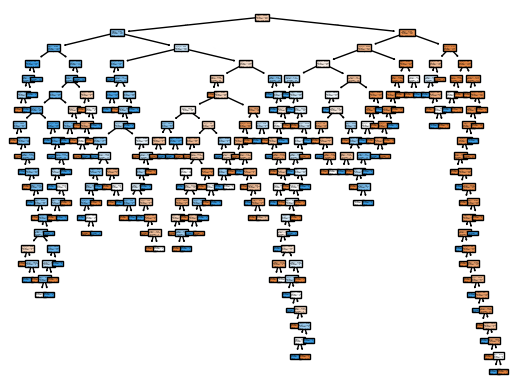

In [5]:
tree.plot_tree(clf, filled=True);

In [6]:
children_left = clf.tree_.children_left # Ids of the nodes with left children nodes
leaf_nodes = np.where(children_left == -1)[0] # Children nodes with value -1 are leaf nodes 

print("There are {0} terminal nodes in this decision tree".format(len(leaf_nodes)))

There are 168 terminal nodes in this decision tree


(d) Use the export_tree() function to produce a text summary of the fitted tree. Pick one of the terminal nodes, and interpret the information displayed.

In [7]:
predictors = list(OJ.columns.drop('Purchase'))
print(export_text(clf, feature_names = predictors, show_weights=True)[:700]) # Truncate the output to keep it sane

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.04
|   |   |   |--- STORE <= 2.50
|   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |--- WeekofPurchase <= 269.50
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: CH
|   |   |   |   |   |--- WeekofPurchase >  269.50
|   |   |   |   |   |   |--- weights: [0.00, 2.00] class: MM
|   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |--- weights: [0.00, 3.00] class: MM
|   |   |   |--- STORE >  2.50
|   |   |   |   |--- weights: [0.00, 43.00] class: MM
|   |   |--- LoyalCH >  0.04
|   |   |   |--- WeekofPurchase <= 273.50
|   |   |   |   |--- SalePriceCH <= 1.94
|   |   |   |   |   |--- WeekofPurchase <= 2


>- The weights in the leaf nodes represent the # of observations of each of the 2 classes
>- If the WeekofPurchase <= 269.50 then the customer purchased Citrus Hill. Otherwise, they purchased Minute Maid.

(e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [8]:
test_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, test_pred)
cm_df = pd.DataFrame(cm, index=['Actual CH','Actual MM'], columns=['Predicted CH','Predicted MM'])
cm_df

,Predicted CH,Predicted MM
Actual CH,123,30
Actual MM,32,85


In [9]:
te_acc = accuracy_score(y_test, test_pred)
print('The test error is {0}'.format(1 - te_acc))

The test error is 0.22962962962962963


(f) Use cross-validation on the training set in order to determine the optimal tree size.

(g) Produce a plot with tree size on the x-axis and cross-validated classification accuracy on the y-axis.

(h) Which tree size corresponds to the highest cross-validated classification accuracy rate?

The highest accuracy is 0.8178 and is achieved with a tree of depth 7


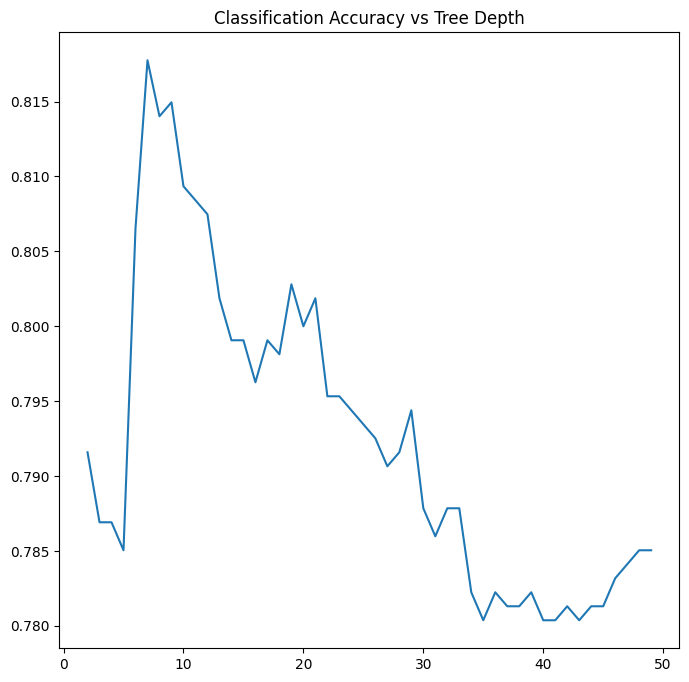

In [10]:
def tune_tree(branches, K):
    results = pd.DataFrame(columns=['Depth', 'Accuracy'])
    for branch in branches:
        # Make a decision tree with the current depth
        model = DTC(criterion='entropy', random_state=0, max_leaf_nodes=branch)
        # Cross-validation with accuracy as scoring
        scores = cross_val_score(model, X, y, cv=K, scoring='accuracy')
        accuracy = np.mean(scores)  # Take the average accuracy
        # Append the values to results 
        new_row = pd.DataFrame({'Depth': [branch], 'Accuracy': [accuracy]})
        results = pd.concat([results, new_row], ignore_index=True)
    return results

# Define depths and run the tuning
depths = np.arange(2, 50)
results_dt = tune_tree(depths, 10)

# Find the depth with the highest accuracy
max_acc_index = results_dt['Accuracy'].idxmax()
max_acc_row = results_dt.loc[max_acc_index]
max_accuracy, best_depth = max_acc_row['Accuracy'], max_acc_row['Depth']
print(f"The highest accuracy is {max_accuracy:.4f} and is achieved with a tree of depth {best_depth}")

# Plot the variation in accuracy as a function of depth
plt.figure(figsize=(8, 8))
plt.plot(results_dt['Depth'], results_dt['Accuracy'])
plt.title('Classification Accuracy vs Tree Depth')
plt.show()

(i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

In [11]:
clf_7 = DTC(criterion='entropy', random_state=0, max_leaf_nodes=7)
clf_7.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=7, random_state=0)

(j) Compare the training error rates between the pruned and unpruned trees. Which is higher?

(k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [12]:
tr_acc_7 = accuracy_score(y_train, clf_7.predict(X_train))
print('The pruned tree has a training error of {0}'.format(1 - tr_acc_7))
print('The unpruned tree has a training error of {0}'.format(1-tr_acc))

The pruned tree has a training error of 0.1775
The unpruned tree has a training error of 0.008750000000000036


In [13]:
te_acc_7 = accuracy_score(y_test, clf_7.predict(X_test))
print('The pruned tree has a test error of {0}'.format(1 - te_acc_7))
print('The unpruned tree has a test error of {0}'.format(1 - te_acc))

The pruned tree has a test error of 0.18888888888888888
The unpruned tree has a test error of 0.22962962962962963


> The unpruned tree does better on the training data, but worse on the testing data. This means that an increase in the tree's depth has caused it to overfit. 